In [1]:
from poloniex import Poloniex
from tusp import string2ts, ts2string
import json
import pandas as pd
import numpy as np
import pylab as plt
%matplotlib inline

polo = Poloniex()

# historyData es una lista de diccionarios python
historyData = polo.returnChartData(currencyPair="BTC_XRP",
                     start=string2ts("2017-04-02 00:00:00"),
                     end=string2ts("2017-05-15 00:00:00"),
                     period=3600*4)

# Guardando los datos como lista de diccionarios en un archivo de texto
# esto permite acceder a ellos y trabajar como data frame offline
with open("XMR_data.out","w") as f:
    json.dump(historyData,f)
    
with open("XMR_data.out") as f:
    historyData = json.load(f)
    #print data

# convirtiendo datos en data frame
df = pd.DataFrame(historyData)

#  convirtiendo string a float o int
df["close"] =pd.to_numeric(df['close'])
df["open"] =pd.to_numeric(df['open'])
df["low"] =pd.to_numeric(df['high'])
df["volume"] =pd.to_numeric(df['volume'])
df["date"] = pd.to_datetime(df["date"].apply(ts2string))

# seleccionando la columna de fecha como indice
df = df.set_index("date")

# examinando las primeras filas
df.head()

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2017-04-02 03:00:00,0.000033,3.499e-5,0.000035,0.000024,1030022822.8089,29510.686423,2.865e-5
2017-04-02 07:00:00,0.000036,3.9e-5,0.000039,0.000033,854384010.47148,30693.821676,3.592e-5
2017-04-02 11:00:00,0.000048,7.075e-5,0.000071,0.000036,971820491.42938,47529.362352,4.89e-5
2017-04-02 15:00:00,0.000057,5.99e-5,0.000060,0.000048,497337489.12959,24635.493846,4.953e-5
2017-04-02 19:00:00,0.000043,5.71e-5,0.000057,0.000057,390091092.78081,19754.086324,5.063e-5


# Calculando retornos, log retornos y sus respectivos acumulados

Retorno final del mercado: 315.274390244


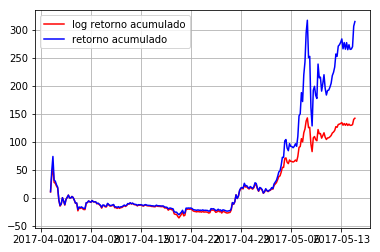

In [2]:
# Calculando retornos relativos
# el 1 se refiere al numero de periodos que se toma para calcular el cambio porcentual
df["retornos relativos"] = df["close"].pct_change(1)

# calculando los log retornos
df["log retornos"] = np.log(df["close"]).diff()

# calculando log retorno acumulado
df["cum_logr"] = df["log retornos"].cumsum()
df["cum_r"] = np.exp(df["cum_logr"]) - 1

plt.plot(df.index,df['cum_logr']*100,'r',label='log retorno acumulado')
plt.plot(df.index,df['cum_r']*100,'b', label='retorno acumulado')
plt.legend()
plt.grid()
print "Retorno final del mercado: %s"%(df["cum_r"][-1]*100)

# Ejemplo estrategía, media movil

Las estrategías funcionan como funciones que como parámetro reciben una serie de pandas o una lista de tamaño $T$ (intervalo de tiempo de estudio divido en el periodo de interés), y devuelven el vector de pesos $\vec{w}$ de tamaño $T\times 2$ y que contiene solo ceros o unos (1 si se posee el determinado activo, 0 si no). La primera columna de $\vec{w}$ corresponde a la posesión del activo de interés, la segunda a la posesión de la moneda por la que se tranza (generalmente **BTC**) 

                      w1   w2 orders
date                                
2017-04-02 03:00:00  0.5  0.5   WAIT
2017-04-02 07:00:00  0.0  1.0   WAIT
2017-04-02 11:00:00  0.0  1.0   WAIT
2017-04-02 15:00:00  1.0  0.0    BUY
2017-04-02 19:00:00  1.0  0.0   WAIT
2017-04-02 23:00:00  1.0  0.0   WAIT
2017-04-03 03:00:00  0.0  1.0   SELL
2017-04-03 07:00:00  0.0  1.0   WAIT
2017-04-03 11:00:00  0.0  1.0   WAIT
2017-04-03 15:00:00  0.0  1.0   WAIT
2017-04-03 19:00:00  0.0  1.0   WAIT
2017-04-03 23:00:00  0.0  1.0   WAIT
2017-04-04 03:00:00  0.0  1.0   WAIT
2017-04-04 07:00:00  0.0  1.0   WAIT
2017-04-04 11:00:00  0.0  1.0   WAIT


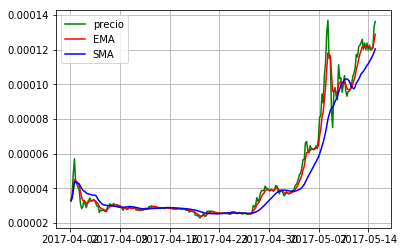

In [3]:
# dada una serie de pandas o una lista y el numero de muestras para la EMA y SMA devuelve vector w
# considerando el cruce entre EMA y SMA
def estrategiaEMAvsSMA(serie, smaPeriod=20,emaPeriod=5):
    
    # Calculando media movil a 20 muestras
    sma = df["close"].rolling(smaPeriod,min_periods=1).mean()
    # caculando exponential movil average
    ema = df["close"].ewm(span=emaPeriod, adjust=False).mean()
    
    
sma = df["close"].rolling(20,min_periods=1).mean()
# caculando exponential movil average
ema = df["close"].ewm(span=5, adjust=False).mean()    

dif = (ema - sma).apply(np.sign)
#w = (w+1)/2
dic = {"w1":(dif+1)/2,"w2":np.abs(-(dif-1)/2)}
w = pd.DataFrame(data=dic)

from orders import orders

w["orders"] = orders(w["w1"])
#w2 = pd.Series(index=w.index, dtype=object)

#print dic
print w.head(15)
plt.plot(df.index,df['close'],'g',label='precio')
plt.plot(df.index,ema,'r',label='EMA')
plt.plot(df.index,sma,'b',label='SMA')
plt.legend()
plt.grid()